# CESM-LE comparison
#### This example looks at monthly changes in fraction of ground covered by snow `FSNO` in N. Hemisphere
 - reading in ensemble of data from CESM1_LENS, CESM2_LENS, and CESM2-CMIP5 a relatively large dataset 
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu


In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
from scipy import stats
%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2020.12.0
dask.__version__

'2021.01.0'

### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300041',
                     walltime='3:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [11]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`

Client Scheduler: tcp://10.12.205.27:36371 Dashboard: http://10.12.205.27/proxy/8787/status,Cluster Workers: 36 Cores: 36 Memory: 375.12 GB


### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [12]:
def get_file(ee,model,field,yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]

    if model == 'CESM2-CMIP5':
        topdir = '/glade/campaign/cesm/development/cross-wg/CESM2_CMIP5_forcings/' 
        mlist = sorted(glob.glob(topdir+'b.e21.BHIST.f09_g17.cesm2_cmip5_forcing*'))
        mm = mlist[ee]
        lnd    = '/lnd/proc/tseries/month_1/'
        ff     = glob.glob(mm+lnd+'*.h0.'+field+'.*')[0]
        
    if model == 'CESM2':
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
        mm = mlist[ee]
        lnd    = '/lnd/proc/tseries/month_1/'
        firstyear = 10*int(yr/10)
        yy    = '.'+str(firstyear)+'01-'+str(firstyear+9)+'12.'
        if yr>2009:
            yy = '.201001-201412.'
        ff     = glob.glob(mm+lnd+'*.h0.'+field+yy+'*')[0]
    return ff

In [13]:
topdir = '/glade/campaign/cesm/development/cross-wg/CESM2_CMIP5_forcings/' 
mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))

topdir = '/glade/campaign/cesm/development/cross-wg/CESM2_CMIP5_forcings/' 
mlist = sorted(glob.glob(topdir+'b.e21.BHIST.f09_g17.cesm2_cmip5_forcing*'))
mm = mlist[1]
        
        #nn      = lenskey[ee]topdir = '/glade/campaign/cesm/development/cross-wg/CESM2_CMIP5_forcings/' 
#mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
print(mm)
    #mm = mlist[0]
#lnd    = '/lnd/proc/tseries/month_1/'
#ff     = glob.glob(mm+lnd+'*.h0.NBP*')[0]
#f

/glade/campaign/cesm/development/cross-wg/CESM2_CMIP5_forcings/b.e21.BHIST.f09_g17.cesm2_cmip5_forcing.002


In [14]:
def all_files(model,field,firstyear,nens):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        files = [get_file(ee,'CESM1',field,0) for ee in range(nens)]
    if model == 'CESM2-CMIP5':
        files = [get_file(ee,'CESM2-CMIP5',field,0) for ee in range(nens)]
    if model =='CESM2':
        yrs = [*np.arange(firstyear,2009,10),2010]
        files = [[get_file(ee,'CESM2',field,yr) for yr in yrs] 
                 for ee in range(nens)]
    return files

In [15]:
def get_monthly(model,fields,firstyear,nens):
    first = True
    
    for field in fields:
        #find the appropriate files
        files = all_files(model,field,firstyear,nens)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2-CMIP5':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                ds = xr.open_mfdataset(files[0],combine='by_coords',parallel=True)
                tmp = xr.open_dataset(files[0][0])
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0])

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model])
        ds[field] = tmp[field]

    ds['landarea'] = ds['area']*ds['landfrac']
    ds['landarea'].name = 'landarea'
    ds['landarea'].attrs['units'] = 'km2'
        
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    ix = ds['time.year']>=firstyear

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)

In [16]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [17]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

# Start editing here:
 - note: you don't have to %%time things
     - just wanted to give a sense of how long various steps take for me

### read in the data:
 - the less data you take, the faster this will run

In [18]:
%%time
#LENS1 starts in 1920, we'll do the same for LENS2

model = ['CESM1','CESM2-CMIP5','CESM2']
# always brackets, fields = ['GPP']
CESM1fields = ['FSNO']
CESM2fields = ['FSNO']
firstyear = 1920
nens = 7
dsCESM1 = get_monthly(model[0],CESM1fields,firstyear,nens)#42
dsCMIP5 = get_monthly(model[1],CESM2fields,firstyear,nens)#7
dsCESM2 = get_monthly(model[2],CESM2fields,firstyear,nens)#50+

CPU times: user 3.44 s, sys: 633 ms, total: 4.08 s
Wall time: 9.27 s


In [51]:
# Now concat into a single dataset
var = ['FSNO','area','landfrac']
ds = xr.concat([dsCESM1[var], dsCMIP5[var], dsCESM2[var]], 'model')
ds.assign_coords({"model": model})


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  r

<xarray.Dataset>
Dimensions:   (ens: 7, lat: 192, lon: 288, model: 3, time: 1140)
Coordinates:
  * time      (time) object 1920-01-01 00:00:00 ... 2014-12-01 00:00:00
  * lat       (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * ens       (ens) int64 0 1 2 3 4 5 6
  * model     (model) <U11 'CESM1' 'CESM2-CMIP5' 'CESM2'
Data variables:
    FSNO      (model, ens, time, lat, lon) float32 dask.array<chunksize=(1, 1, 120, 192, 288), meta=np.ndarray>
    area      (model, lat, lon) float32 29.95 29.95 29.95 29.95 ... nan nan nan
    landfrac  (model, lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan
Attributes:
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Wed Jul 24 09:52:35 2013: /glade/ap...
    source:                               Community Land Model CLM4.0
    hostname:                             yellowstone
    username:                             mai
    version:                              cesm1_1_1_alpha01g
    revision_id:                          $Id: histFileMod.F90 40539 2012-09-...
    case_title:                           UNSET
    case_id:                              b.e11.B20TRC5CNBDRD.f09_g16.001
    Surface_dataset:                      surfdata_0.9x1.25_simyr1850_c110921.nc
    Initial_conditions_dataset:           b.e11.B1850C5CN.f09_g16.005.clm2.r....
    PFT_physiological_constants_dataset:  pft-physiology.c110425.nc
    nco_openmp_thread_number:             1
    NCO:                                  4.1.0

In [ ]:
# monthly global snow fraction
ds_sum = (ds.area * ds.landfrac * ds.FSNO).sel(lat=slice(40,90)).sum(dim=['lat','lon'])
#dsCESM1_ann 
#dsCESM1_sum.transpose('time','ens').plot.line(x='time')
ds_sum.isel(time=slice(0,120)).groupby('time.month').mean().mean('ens').plot.line(x='month',hue='model');

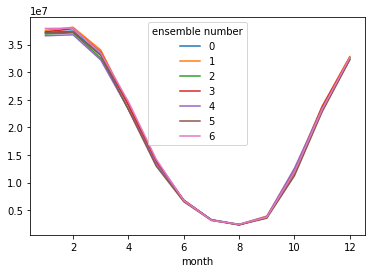

In [44]:
dsCESM2_sum.isel(time=slice(-120,None)).groupby('time.month').mean().transpose('month','ens').plot.line(x='month');

In [20]:
#Set up datasets to save output
globCESM1,cumCESM1 = {},{}
globCMIP5,cumCMIP5 = {},{}
globCESM2,cumCESM2 = {},{}

nyearsCESM1  = len(np.unique(dsCESM1['time.year']))
nyearsCMIP5  = len(np.unique(dsCMIP5['time.year']))
nyearsCESM2  = len(np.unique(dsCESM2['time.year']))

cf = 24*60*60           # used to convert /s to /d
dpmCESM1 = month_wts(nyearsCESM1) # days per month
dpmCMIP5 = month_wts(nyearsCMIP5) 
dpmCESM2 = month_wts(nyearsCESM2) 

### Calculate annual, global & cumulative fluxes

In [22]:
%%time
var = ['FSNO']
for i in range(len(var)):
    if i < 5: #convert annual    
        # gridded annual flux
        annCESM1[var[i]] = cf*(dpmCESM1*dsCESM1[var[i]]).groupby('time.year').sum(skipna=True) 
        annCMIP5[var[i]] = cf*(dpmCMIP5*dsCMIP5[var[i]]).groupby('time.year').sum(skipna=True)
        annCESM2[var[i]] = cf*(dpmCESM2*dsCESM2[var[i]]).groupby('time.year').sum(skipna=True) 
    else:
        # gridded stock
        annCESM1[var[i]] = (dpmCESM1/365*dsCESM1[var[i]]).groupby('time.year').sum(skipna=True) 
        annCMIP5[var[i]] = (dpmCMIP5/365*dsCMIP5[var[i]]).groupby('time.year').sum(skipna=True) 
        annCESM2[var[i]] = (dpmCESM2/365*dsCESM2[var[i]]).groupby('time.year').sum(skipna=True) 
        
    # Global sum
    globCESM1[var[i]]= (annCESM1[var[i]]*dsCESM1['area']*dsCESM1['landfrac']).sum(dim=['lat','lon'],skipna=True) * 1e-9 #PgC
    globCMIP5[var[i]]= (annCMIP5[var[i]]*dsCMIP5['area']*dsCMIP5['landfrac']).sum(dim=['lat','lon'],skipna=True) * 1e-9 #PgC
    globCESM2[var[i]]= (annCESM2[var[i]]*dsCESM2['area']*dsCESM2['landfrac']).sum(dim=['lat','lon'],skipna=True) * 1e-9 #PgC

    # Cumulative annual flux over time
    if i < 4:   
        # force calculations to be done
        cumCESM1[var[i]] = globCESM1[var[i]].cumsum(dim='year').load()
        cumCMIP5[var[i]] = globCMIP5[var[i]].cumsum(dim='year').load()
        cumCESM2[var[i]] = globCESM2[var[i]].cumsum(dim='year').load()

CPU times: user 1min 10s, sys: 1.6 s, total: 1min 12s
Wall time: 1min 39s


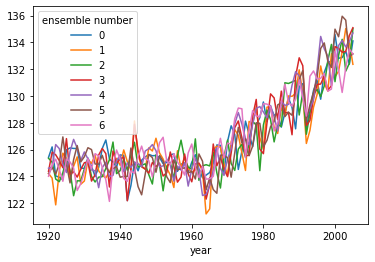

In [23]:
# quick look to see that fluxese are sensible
globCESM1['GPP'].plot.line(x='year');

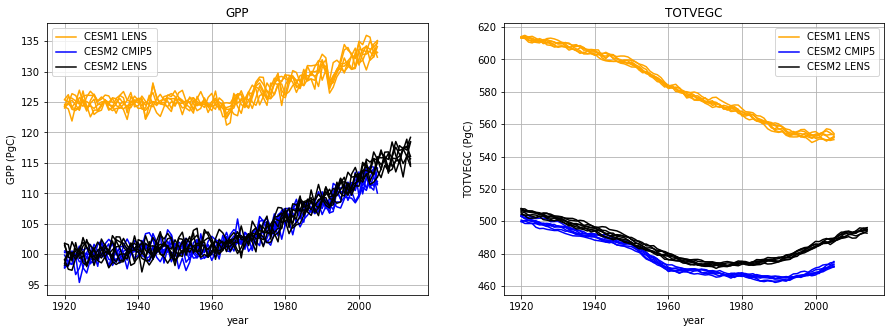

In [24]:
import matplotlib.lines as mlines

#var = ['NBP','NEP','NEE','LULCCdir','GPP','TOTVEGC']
var = ['GPP','TOTVEGC']
col = ['orange','blue','black']
plt.figure(figsize=[15,5])

for i in range(len(var)):
    plt.subplot(1,2,(i+1))
    plt.plot(globCESM1[var[i]].year,globCESM1[var[i]],color=col[0])
    plt.plot(globCMIP5[var[i]].year,globCMIP5[var[i]],color=col[1])
    plt.plot(globCESM2[var[i]].year,globCESM2[var[i]],color=col[2])
    plt.grid()
    plt.ylabel(var[i]+' (PgC)');
    plt.xlabel('year')
    plt.title(var[i])
    cesm1_line = mlines.Line2D([], [], color=col[0], label='CESM1 LENS')
    cmip5_line = mlines.Line2D([], [], color=col[1], label='CESM2 CMIP5')
    cesm2_line = mlines.Line2D([], [], color=col[2], label='CESM2 LENS')
    plt.legend(handles=[cesm1_line,cmip5_line,cesm2_line]);

### What fluxes are driving differences in TOTVEGC? 
- NEP = GPP - ER
- NEE = NEP - FIRE
- NBP = NEE - LULCC - Harvest

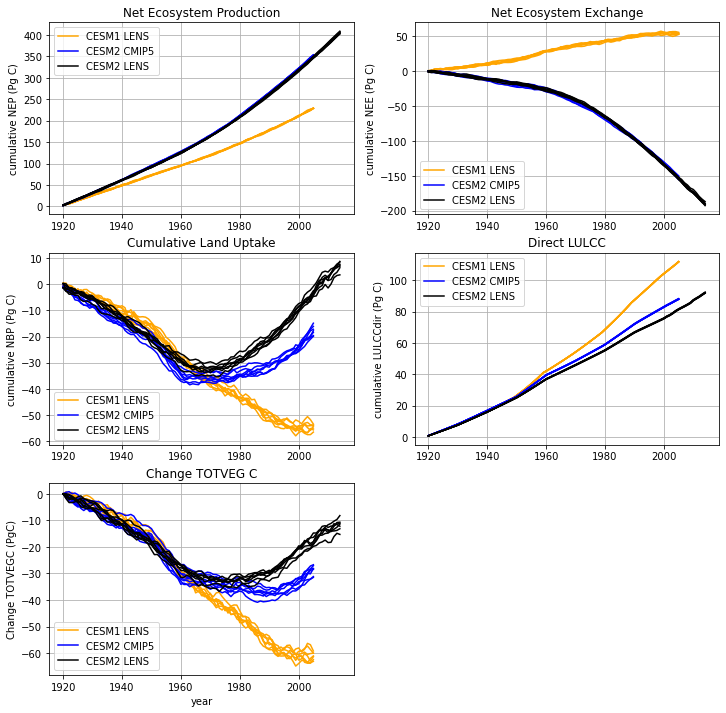

In [25]:
var = ['NEP','NEE','NBP','LULCCdir']
col = ['orange','blue','black']
varLong = ['Net Ecosystem Production','Net Ecosystem Exchange',
          'Cumulative Land Uptake','Direct LULCC']
plt.figure(figsize=[12,12])

for i in range(len(var)):
    plt.subplot(3,2,(i+1))
    plt.plot(cumCESM1[var[i]].year,cumCESM1[var[i]],color=col[0])
    plt.plot(cumCMIP5[var[i]].year,cumCMIP5[var[i]],color=col[1])
    plt.plot(cumCESM2[var[i]].year,cumCESM2[var[i]],color=col[2])
    plt.grid()
    plt.ylabel('cumulative '+var[i]+' (Pg C)');
    plt.xlabel('')
    plt.title(varLong[i])
    cesm1_line = mlines.Line2D([], [], color=col[0], label='CESM1 LENS')
    cmip5_line = mlines.Line2D([], [], color=col[1], label='CESM2 CMIP5')
    cesm2_line = mlines.Line2D([], [], color=col[2], label='CESM2 LENS')
    plt.legend(handles=[cesm1_line,cmip5_line,cesm2_line]);
    
# add plot of change in TOTVEGC over time
plt.subplot(3,2,5)
plt.plot(globCESM1[var[i]].year,(globCESM1['TOTVEGC']-globCESM1['TOTVEGC'].isel(year=0)),color=col[0])
plt.plot(globCMIP5[var[i]].year,(globCMIP5['TOTVEGC']-globCMIP5['TOTVEGC'].isel(year=0)),color=col[1])
plt.plot(globCESM2[var[i]].year,(globCESM2['TOTVEGC']-globCESM2['TOTVEGC'].isel(year=0)),color=col[2])
plt.grid()
plt.ylabel('Change TOTVEGC (PgC)');
plt.xlabel('year')
plt.title('Change TOTVEG C')
cesm1_line = mlines.Line2D([], [], color=col[0], label='CESM1 LENS')
cmip5_line = mlines.Line2D([], [], color=col[1], label='CESM2 CMIP5')
cesm2_line = mlines.Line2D([], [], color=col[2], label='CESM2 LENS')
plt.legend(handles=[cesm1_line,cmip5_line,cesm2_line]);

In [27]:
print('CMIP5 cum LULCC = '+str(np.round(cumCMIP5[var[3]].sel(year=2005).mean().values,1)) +
     ', cum NBP = '+str(np.round(cumCMIP5[var[2]].sel(year=2005).mean().values,1))+
     ', delta TOTVEGC = '+str(np.round((globCMIP5['TOTVEGC'].sel(year=2005)-globCMIP5['TOTVEGC'].isel(year=0)).mean().values,1)))

print('CESM2 cum LULCC = '+str(np.round(cumCESM2[var[3]].sel(year=2005).mean().values,1))+
     ', cum NBP = '+str(np.round(cumCESM2[var[2]].sel(year=2005).mean().values,1))+
     ',  delta TOTVEGC = '+str(np.round((globCESM2['TOTVEGC'].sel(year=2005)-globCESM2['TOTVEGC'].isel(year=0)).mean().values,1)))



CMIP5 cum LULCC = 88.0, cum NBP = -17.7, delta TOTVEGC = -28.7
CESM2 cum LULCC = 81.5, cum NBP = -3.2,  delta TOTVEGC = -17.9


### WOOD harvest to product pool same in CMIP5 forced simulations
- Cumulative flux here isnt enough to account for differences in NBP & VEGC
- Additional fluxes needed?


-----------------------
### Generate maps to look at initial VEG C stocks and their change over time 

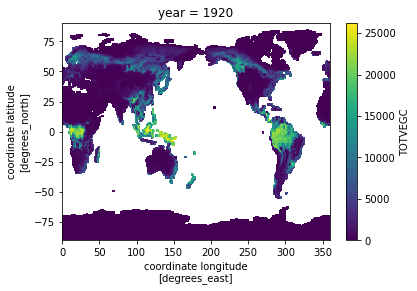

In [28]:
#dsCMIP5.TOTVEGC.groupby('time.year').mean(skipna=True).mean('ens').isel(year=0).plot();

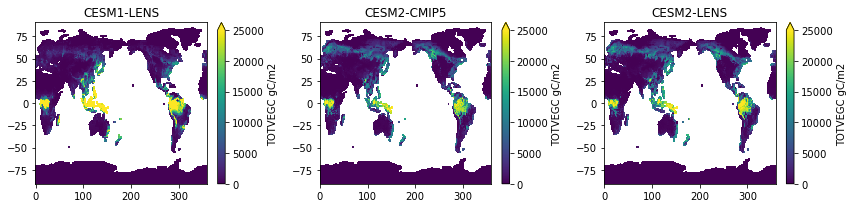

In [32]:
ncols = 3
nrows = 1
#  lists of variables, titles & labels
plotVars = ['TOTVEGC']
plotTitle = ['CESM1-LENS','CESM2-CMIP5','CESM2-LENS']
plotLabel = 'TOTVEGC gC/m2'

# create the plots
fig = plt.figure(figsize=(12,3))
axes = [ fig.add_subplot(nrows, ncols, 1+ r * ncols + c) for r in range(0, nrows) for c in range(0, ncols) ]

# add some data
i = 0
for ax in axes:
    if i == 0: ds = dsCESM1.TOTVEGC.groupby('time.year').mean(skipna=True).mean('ens')
    if i == 1: ds = dsCMIP5.TOTVEGC.groupby('time.year').mean(skipna=True).mean('ens')
    if i == 2: ds = dsCESM2.TOTVEGC.groupby('time.year').mean(skipna=True).mean('ens')
     
    ds.isel(year=-1).plot(ax=ax, robust=True, cbar_kwargs={'label': plotLabel},vmax=25e3, vmin=0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(plotTitle[i])
    i = i+1

plt.tight_layout()


In [34]:
tempA = dsCESM1.TOTVEGC.groupby('time.year').mean(skipna=True).mean('ens')
tempB = dsCMIP5.TOTVEGC.groupby('time.year').mean(skipna=True).mean('ens')
tempC = dsCESM2.TOTVEGC.groupby('time.year').mean(skipna=True).mean('ens')
print(tempA)

<xarray.DataArray 'TOTVEGC' (year: 86, lat: 192, lon: 288)>
dask.array<mean_agg-aggregate, shape=(86, 192, 288), dtype=float32, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year     (year) int64 1920 1921 1922 1923 1924 ... 2001 2002 2003 2004 2005


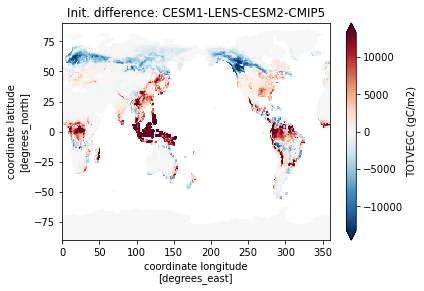

In [38]:
# Difference between inital stocks (CESM1-LENS - CESM2-CMIP5)
y = 0
(tempA.isel(year=y)-tempB.isel(year=y)).plot(robust=True, cbar_kwargs={'label': 'TOTVEGC (gC/m2)'});
plt.title('Init. difference: '+plotTitle[0]+'-'+plotTitle[1]);

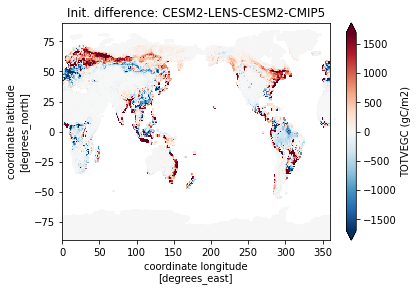

In [37]:
# CESM2 differences at Start of simulation 
y = 0
(tempC.isel(year=y)-tempB.isel(year=y)).plot(robust=True,cbar_kwargs={'label': 'TOTVEGC (gC/m2)'});#,vmax=2000,vmin=-2000);
plt.title('Init. difference: '+plotTitle[2]+'-'+plotTitle[1]);

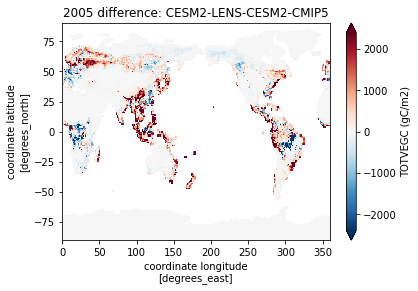

In [40]:
# CESM2 differences at end of simulation, here looking at results in 2005
y = 2005
(tempC.sel(year=y)-tempB.sel(year=y)).plot(robust=True,cbar_kwargs={'label': 'TOTVEGC (gC/m2)'});#,vmax=2000,vmin=-2000);
plt.title(str(y)+' difference: '+plotTitle[2]+'-'+plotTitle[1]);

### CESM2-LENS accumulates more C relative to CESM2-CMIP5
- Largely in tropics, especially in SE Asia?

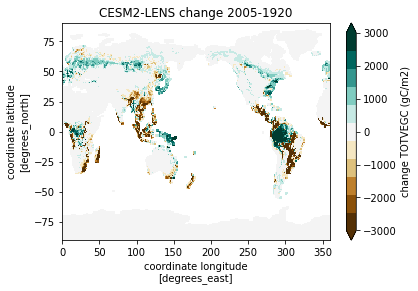

In [44]:
# Change in CESM2-LENS
y = [2005, 1920]
cesm2_lens_delta = (tempC.sel(year=y[0])-tempC.sel(year=y[1]))
cesm2_lens_delta.plot(robust=True,cbar_kwargs={'label': 'change TOTVEGC (gC/m2)'},
                     cmap=ccc,vmax=3e3,vmin=-3e3);
plt.title(plotTitle[2]+' change '+str(y[0])+'-'+str(y[1]));

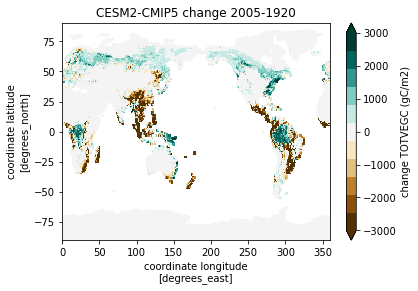

In [45]:
# Change in CESM2-CMIP5
cesm2_cmip5_delta = (tempB.sel(year=y[0])-tempB.sel(year=y[1]))
cesm2_cmip5_delta.plot(robust=True,cbar_kwargs={'label': 'change TOTVEGC (gC/m2)'},
                     cmap=ccc,vmax=3e3,vmin=-3e3);
plt.title(plotTitle[1]+' change '+str(y[0])+'-'+str(y[1]));

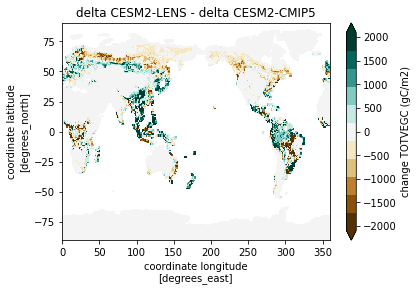

In [46]:
(cesm2_lens_delta - cesm2_cmip5_delta).plot(robust=True,cbar_kwargs={'label': 'change TOTVEGC (gC/m2)'},cmap=ccc);
plt.title('delta '+plotTitle[2]+' - delta '+plotTitle[1]);

In [14]:


client.close()